# tabular data interpretation and explaination

## Pre processing

In [7]:
df = pd.read_csv('df_sample.csv')
df_proc, y, pp_outp = tabular_proc(df, 'TARGET', [fill_na(), app_cat(), dummies()])

Unify class for pre processing class. 

In [ ]:
class cls(TBPreProc):
    @staticmethod
    def func(df, pp_outp, na_dict = None):
        ...
        return df

For example, fill_na class

In [ ]:
class fill_na(TBPreProc):
    @staticmethod
    def func(df, pp_outp, na_dict = None):
        na_dict = {} if na_dict is None else na_dict.copy()
        na_dict_initial = na_dict.copy()
        for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
        if len(na_dict_initial.keys()) > 0:
            df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
        pp_outp['na_dict'] = na_dict
        return df

## Dataset

Dataset can be build by use split method by SKlearn

In [11]:
ds= TBDataset.from_SKSplit(df_proc, y, cons, cats, ratio = 0.2)

Or by split method by tabint. This method will try to keep distribution of categories between training set and validation set

In [ ]:
ds= TBDataset.from_TBSplit(df_proc, y, cons, cats, ratio = 0.2)

Dataset class contain training set, validation set and test set.

## Learner

Learner class unify training method from sklearn model, LGBM model and XGB model

In [30]:
learner = LGBLearner()
params = {'task': 'train', 'objective': 'binary', 'metric':'binary_logloss'}
learner.fit(params, *ds.trn, *ds.val)

Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.23814	valid_1's binary_logloss: 0.247746
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.23814	valid_1's binary_logloss: 0.247746


In [21]:
learner = SKLearner(RandomForestClassifier())
learner.fit(*ds.trn, *ds.val)

trn accuracy:  0.985715911677669
val accuracy:  0.9176300343072695


## Feature correlation

In [10]:
ddg = Dendogram.from_df(ds.x_trn)

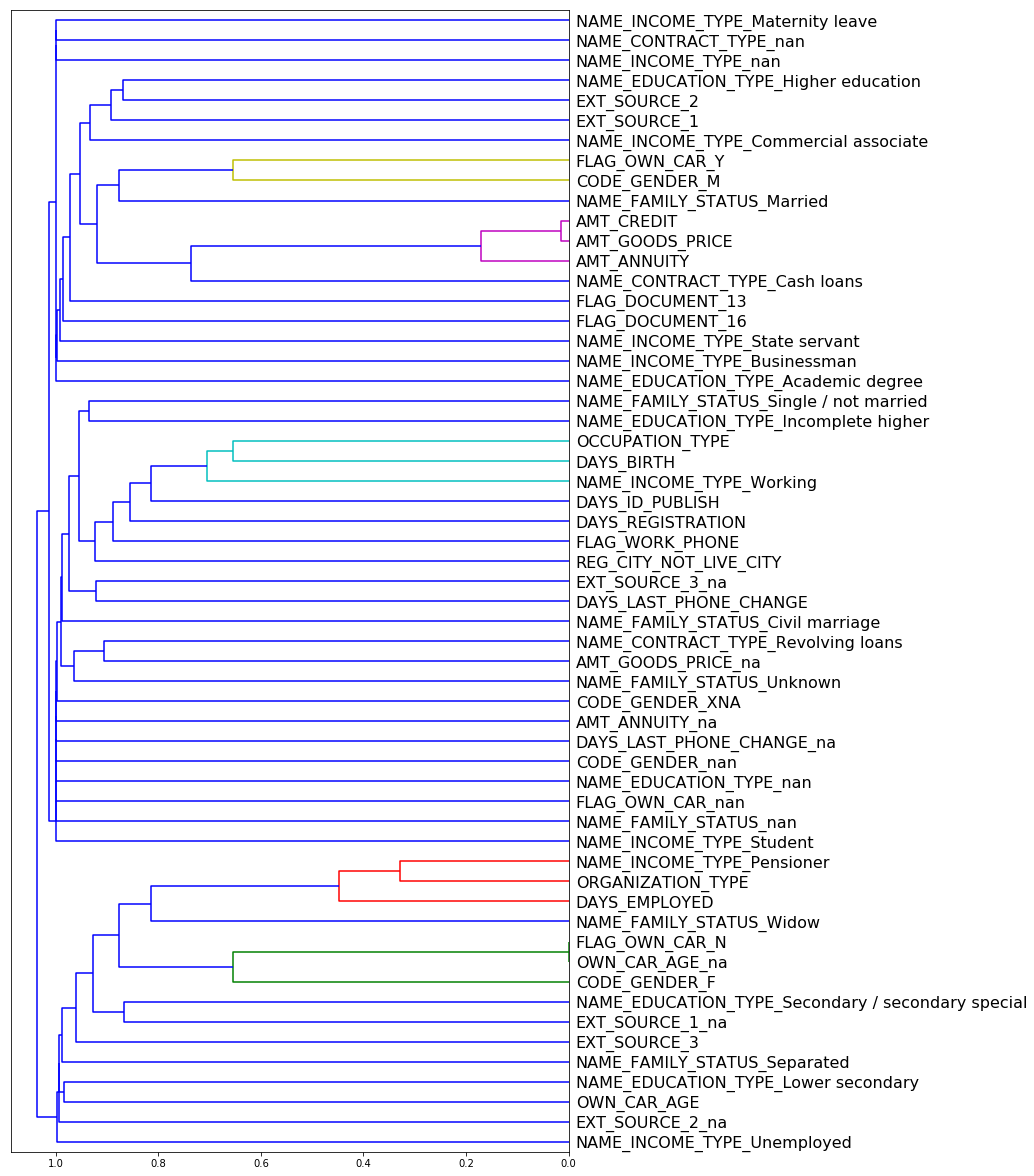

In [11]:
ddg.plot()

## Feature importance

tabint use [permutation importance](http://explained.ai/rf-importance/index.html). Each column or group of columns in validation set in dataset will be permute to calculate the importance.

In [13]:
group_cols = [['AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_ANNUITY'], ['FLAG_OWN_CAR_N', 'OWN_CAR_AGE_na']]

In [14]:
impt = Importance.from_Learner(learner, ds, group_cols)

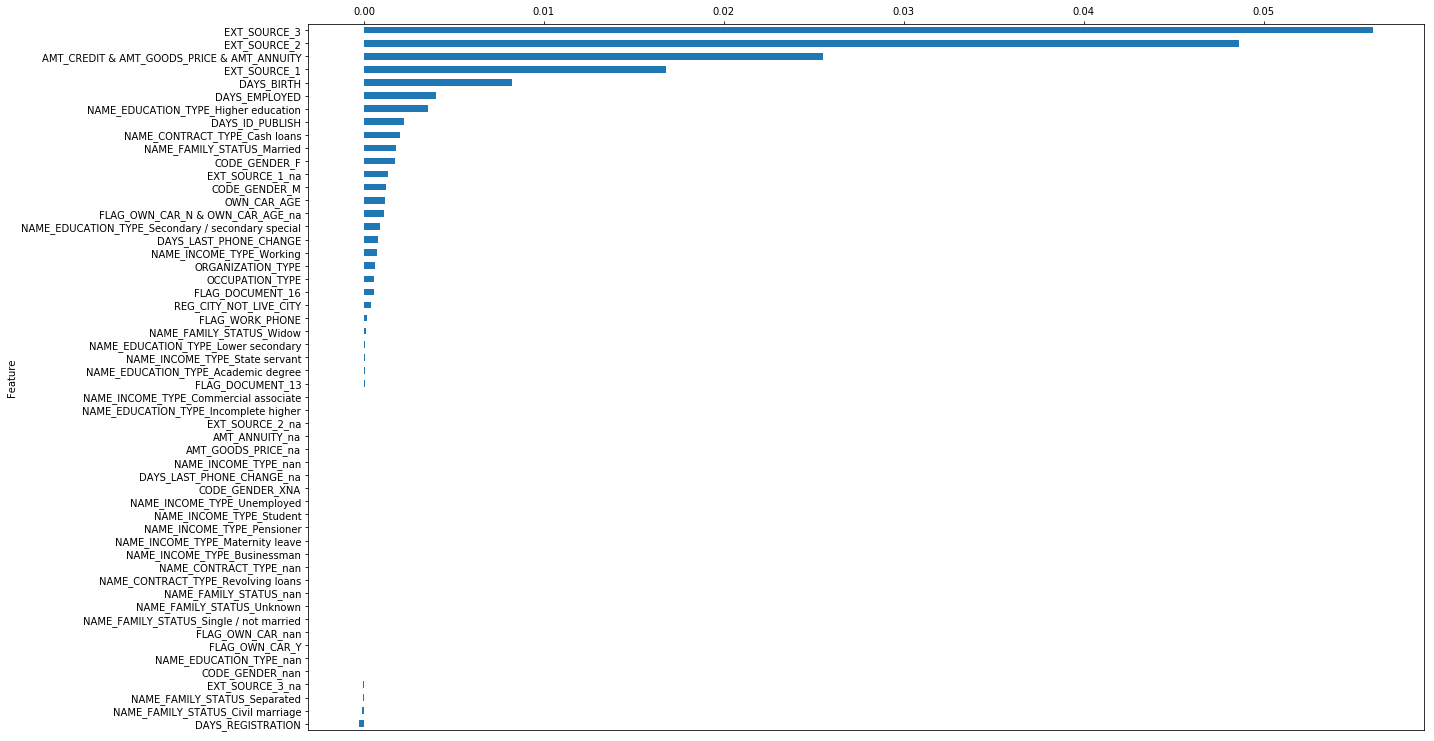

In [15]:
impt.plot()

We can easily get the most importance feature by method in Importance class

In [16]:
impt.top_features(24)

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_ANNUITY',
 'EXT_SOURCE_1',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'NAME_EDUCATION_TYPE_Higher education',
 'DAYS_ID_PUBLISH',
 'NAME_CONTRACT_TYPE_Cash loans',
 'NAME_FAMILY_STATUS_Married',
 'CODE_GENDER_F',
 'EXT_SOURCE_1_na',
 'CODE_GENDER_M',
 'OWN_CAR_AGE',
 'FLAG_OWN_CAR_N',
 'OWN_CAR_AGE_na',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'DAYS_LAST_PHONE_CHANGE',
 'NAME_INCOME_TYPE_Working',
 'ORGANIZATION_TYPE',
 'OCCUPATION_TYPE',
 'FLAG_DOCUMENT_16',
 'REG_CITY_NOT_LIVE_CITY',
 'FLAG_WORK_PHONE',
 'NAME_FAMILY_STATUS_Widow']

Dataset class have method that can edit training set, validation set and test set.

Drop method can drop one or many columns in training set, validation set and test set.

In [17]:
ds.drop('DAYS_LAST_PHONE_CHANGE_na')

Or if we need to keep only importance columns that we found above. Just use keep method from dataset.

In [18]:
impt_features = impt.top_features(24)
ds.keep(impt_features)

In [19]:
ds.features

Index(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
       'AMT_ANNUITY', 'EXT_SOURCE_1', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'NAME_EDUCATION_TYPE_Higher education', 'DAYS_ID_PUBLISH',
       'NAME_CONTRACT_TYPE_Cash loans', 'NAME_FAMILY_STATUS_Married',
       'CODE_GENDER_F', 'EXT_SOURCE_1_na', 'CODE_GENDER_M', 'OWN_CAR_AGE',
       'FLAG_OWN_CAR_N', 'OWN_CAR_AGE_na',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'DAYS_LAST_PHONE_CHANGE', 'NAME_INCOME_TYPE_Working',
       'ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'FLAG_DOCUMENT_16',
       'REG_CITY_NOT_LIVE_CITY', 'FLAG_WORK_PHONE',
       'NAME_FAMILY_STATUS_Widow'],
      dtype='object')

You can read source code of dataset class for more usefull method.

## Interpretation and explaination

### Partial dependence

tabint use [PDPbox library](https://github.com/SauceCat/PDPbox) to visualize partial dependence.

In [17]:
pdp = PartialDependence.from_Learner(learner, ds)

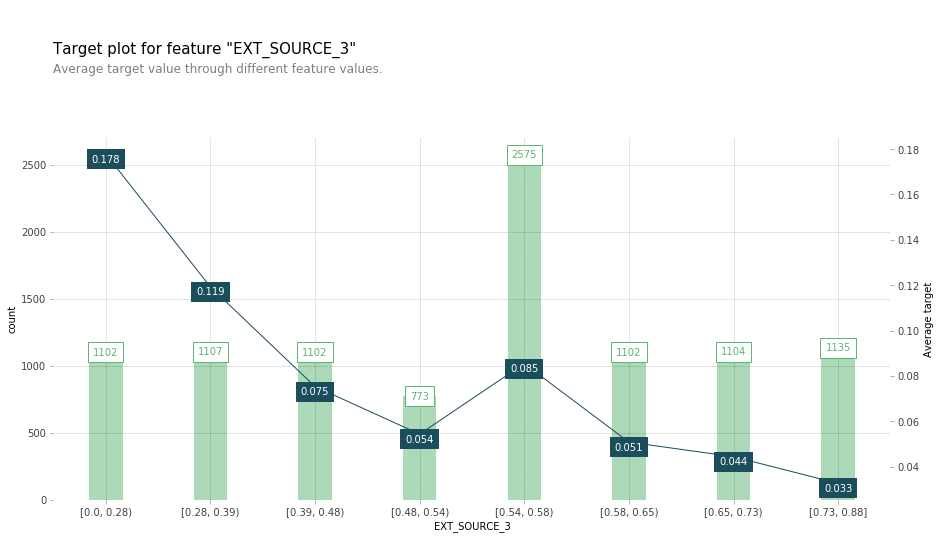

In [18]:
pdp.info_target('EXT_SOURCE_3')

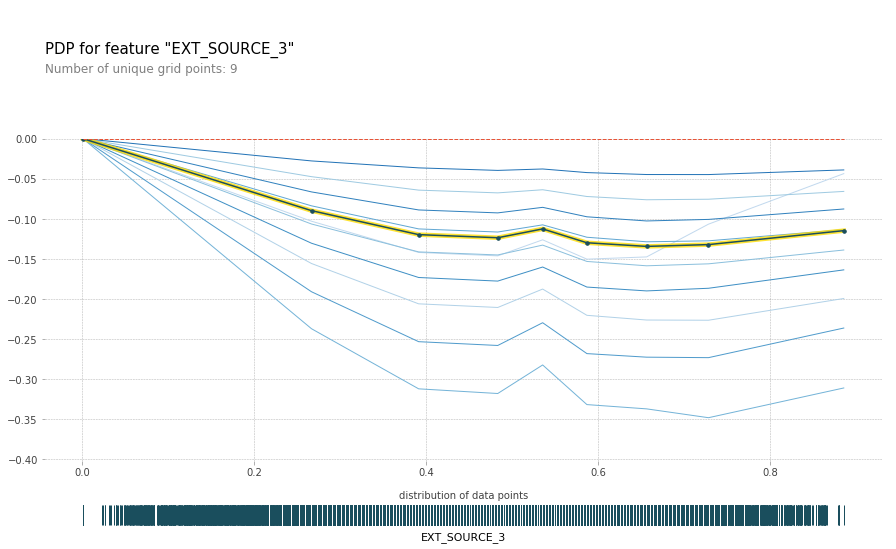

In [19]:
pdp.isolate('EXT_SOURCE_3')

### Tree interpreter

In [22]:
Tf = Traterfall.from_SKTree(learner, ds.x_trn, 3)

ValueError: bottom cannot be >= top

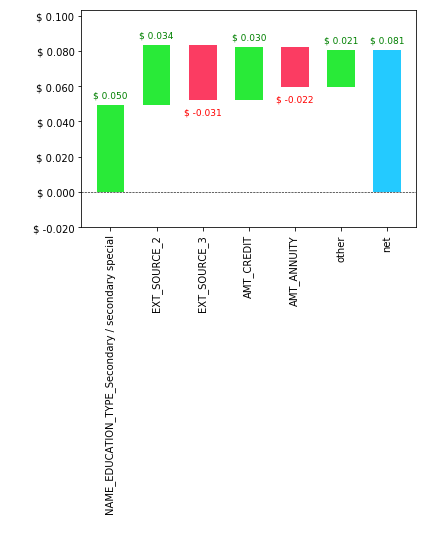

In [24]:
Tf.plot(formatting = "$ {:,.3f}")

### SHAP

tabint visual SHAP values from [SHAP library](https://github.com/slundberg/shap). SHAP library use red and blue for default color. tabint change these color to green and blue for easy to see and consistence with pdpbox library.

In [31]:
Shap = SHAP.from_Tree(learner, ds)

In [32]:
Shap.force_plot_one(3)

In [34]:
Shap.force_value_one.pos(5)

,Column name,Column value,Shap value
0,EXT_SOURCE_3,0.253963,0.720332
5,EXT_SOURCE_1,0.290425,0.185534
3,AMT_GOODS_PRICE,247500.000000,0.127218
24,REG_CITY_NOT_LIVE_CITY,1.000000,0.071174
9,DAYS_ID_PUBLISH,-520.000000,0.052655


In [35]:
Shap.force_value_one.neg(5)

,Column name,Column value,Shap value
2,AMT_CREDIT,267102.0,-0.260664
15,OWN_CAR_AGE,3.0,-0.128298
16,FLAG_OWN_CAR_N,0.0,-0.068803
13,EXT_SOURCE_1_na,0.0,-0.043089
6,DAYS_BIRTH,-11185.0,-0.032210


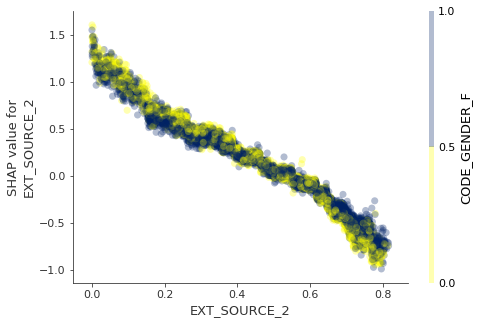

In [21]:
Shap.dependence_plot('EXT_SOURCE_2')